# Encoding и Decoding аббревиатур

В этом ноутбуке и попытаемся найти в текстах не закодированные медицинские аббревиатуры и сохраним их индексы. Будем работать с выборкой `anamnesis.csv.csv`

In [1]:
import pandas as pd
import numpy as np

Так как Python очень медленный, было решено решить эту задачу на плюсах (см. find_abbrs.cpp) и они были сохранены в файл `term_indexes.csv`

Загрузим найденные термины в текстах

In [2]:
df_terms_indexes = pd.read_csv('data/term_indexes.csv', sep=';', header=None)
df_terms_indexes.columns =['text_id', 'term']

In [3]:
df_terms_indexes.head()

,text_id,term
0,37,верхушечный толчок
1,68,родильный дом
2,72,перкуторный звук
3,279,лекарственный препарат
4,376,лекарственный препарат


Сопоставим с текстом

In [4]:
df_texts = pd.read_csv('data/anamnesis.csv.csv', sep='\t')

In [5]:
df_terms_indexes['doc_text'] = df_terms_indexes.text_id.apply(lambda x: df_texts.norm_part[x])

AttributeError: 'DataFrame' object has no attribute 'norm_part'

In [267]:
import re

def abbr_by_first_letters(x):
    return "".join([a[0] for a in re.split('[- ]', x) if len(a) > 0])

In [268]:
df_terms_indexes['term_encoded'] = df_terms_indexes.term.map(abbr_by_first_letters)

Зададим каждому термину id

In [269]:
idx2term = sorted(set(df_terms_indexes.term))
term2idx = {u: i for i, u in enumerate(idx2term)}

df_terms_indexes['term_id'] = df_terms_indexes.term.map(term2idx.get)

In [270]:
df_terms_indexes.head()

,text_id,term,doc_text,term_encoded,term_id
0,37,верхушечный толчок,пульс в мина. ритмичный. удовлетворительный на...,вт,6
1,68,родильный дом,порядок настоящий беременность анамнез известн...,рд,30
2,72,перкуторный звук,переносимость физ. нагрузка удовлетворительный...,пз,24
3,279,лекарственный препарат,приём. жалоба на головной боль. повышение ад д...,лп,14
4,376,лекарственный препарат,приём. первичный амбулаторный. жалоба. одышка ...,лп,14


Найдем количество документов с данными терминами

In [271]:
term_counter = df_terms_indexes.groupby('term_id').count()['text_id']

In [272]:
df_terms_indexes['term_count'] = df_terms_indexes.term_id.apply(lambda x: term_counter[x])

In [273]:
df_terms_indexes.head()

,text_id,term,doc_text,term_encoded,term_id,term_count
0,37,верхушечный толчок,пульс в мина. ритмичный. удовлетворительный на...,вт,6,108
1,68,родильный дом,порядок настоящий беременность анамнез известн...,рд,30,13
2,72,перкуторный звук,переносимость физ. нагрузка удовлетворительный...,пз,24,1235
3,279,лекарственный препарат,приём. жалоба на головной боль. повышение ад д...,лп,14,1642
4,376,лекарственный препарат,приём. первичный амбулаторный. жалоба. одышка ...,лп,14,1642


<Figure size 720x720 with 0 Axes>

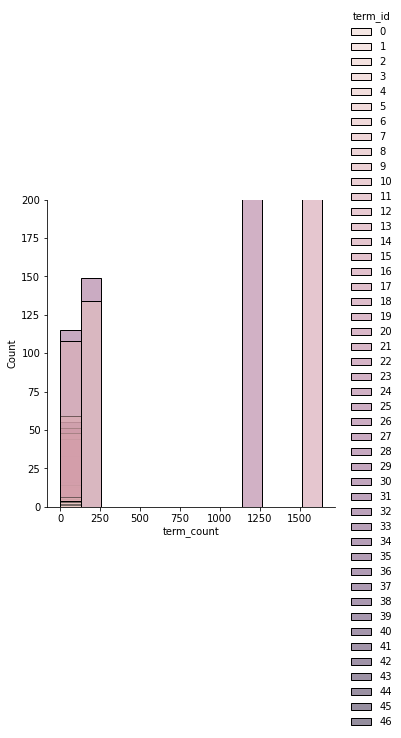

In [321]:
plt.figure(figsize=(10, 10))
sns.displot(x='term_count', hue='term_id', data=df_terms_indexes)
plt.ylim(0, 200)
plt.show()

Оставим только те термины, которые встречаются более 250 раз

In [322]:
df_terms_stripped = df_terms_indexes[
    np.logical_and(
        df_terms_indexes.term_count >= 100, 
        df_terms_indexes.term_count <= 300)]

In [323]:
df_terms_stripped.head()

,text_id,term,doc_text,term_encoded,term_id,term_count
0,37,верхушечный толчок,пульс в мина. ритмичный. удовлетворительный на...,вт,6,108
24,839,больничный лист,жалоба боль в горло при глотание справа. перио...,бл,3,134
33,929,больничный лист,жалоба на боль в грудной клетка. локализация б...,бл,3,134
41,1051,протромбиновое время,мм. контур неровный. паренхима мм. неоднородны...,пв,28,115
42,1056,протромбиновое время,мм. контур неровный. паренхима мм. неоднородны...,пв,28,115


In [324]:
df_terms_stripped.shape

(506, 6)

Выведем уникальные словосочетания для каждых из аббревиатур

In [325]:
df_terms_stripped.groupby('term_encoded').term.nunique().sort_values(ascending=False).head()

term_encoded
пп    1
пв    1
вт    1
бл    1
Name: term, dtype: int64

Как мы видим, каждой аббревиатуре соотвествует только одно словосочетание(если будем запоминать закодированные обозначения, то мы переобучимся)

Закодируем найденные аббревиатуры в три шага:

1. Найдем кодировку термина (в этом случае мы считаем, что аббревиатура это первые слова словосочетания)
2. Завернем аббревиатуру в фигурные скобки: ад -> {ад}
3. Заменим в тексте словосочетание на завернутую аббревиатуру

'артериальное давление' -> 'ад' -> '{ад}'

In [298]:
def replace_terms_at_texts(text):
    global ind
    
    term = df_terms_stripped.term.iloc[ind]
    ind += 1
    
    return text.replace(term, "{%s}" % abbr_by_first_letters(term))

In [299]:
ind = 0
df_terms_stripped.doc_text = df_terms_stripped.doc_text.apply(lambda text: replace_terms_at_texts(text))

/Users/michil/.virtualenvs/cs102/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [302]:
print('Пример')
print('Текст:', df_terms_stripped.doc_text.iloc[0])
print('Аббревиатура:', df_terms_stripped.term.iloc[0])

Пример
Текст: переносимость физ. нагрузка удовлетворительный. состояние удовлетворительный. показатель физический развитие. вес килограмм. рост сантиметр. индекс масса тело. соотв. нервно психический развитие соотв. возраст. подкожно жировой клетчатка развитый удовлетворительно. отечь нет. мышечный система развитый удовлетворительно. сустав не изменить. одышка нет. {пз} не изменить. дыхание везикулярный. хрип нет. пульс ритмичный стоя в мина лёжа в мина после физ нагр в мина сидеть мм рт ст на нога мм рт ст бедренный пульс удовлетворительный с оба сторона. граница сердце соответствовать возраст. тон сердце отчётливый. систолический шум у верхушка. в точка боткин. с хордальным оттенок. живот мягкий. безболезненный. печень не пальпируется. стул нормальный. мочеиспускание нормальный
Аббревиатура: перкуторный звук


## Декодер

Алгоритм обучения модели:

- На вход подается текст с замененной аббревиатурой и ее расшифровкой
- Мы делим текст на три части: текст до аббревиатуры(ТД), сама аббревиатура(АБ) и текст после аббревиатуры(ТП)
('ее показание {ад} вышло за пределы' -> ('ее показание', 'ад', 'вышло за пределы')
- Затем для векторов ТД и ТП обучим TfidfVectorizer и получим фичи слов до и после аббревитуры
- Саму аббревиатуру сделаем вектором для каждого уникального символа входных текстов сопоставим id. Тогда длина вектора аббревиатур будет равна количеству уникальный символом, если char_i входит в аббревиатуру, тогда i элемент равен 1.
- Объединение векторов ТД, ТП и АБ будет обучающей выборкой (так как сейчас значений аббревиатур не так много, модель переобучится из-за векторов АБ)

(пусть всего три символа в выборке: {'a': 0, 'д': 1, 'с': 2}: тогда 'ад' = [1, 1, 0]'


In [303]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [305]:
class AbbreviationDecoder:
    own_attributes = ['model', 'window', 'use_abbr_letters']
    
    def __init__(self, model, window=None, use_abbr_letters=True, **kwargs):
        """
        model: sklearn модель
        window: количество слов, рассматриваемая справа и слева аббревиатуры
        use_abbr_letters: нужно ли использовать буквы аббревиатур
        """
        
        self.window = window
        self.use_abbr_letters = use_abbr_letters
        
        self.model = model
        self.model.set_params(**kwargs)
        
    def init_chars(self, X_train):
        """ Зададим каждому символу уникальный id. """
        self.idx2char = sorted(set("".join(X_train.to_list())))
        self.char2idx = {u:i for i, u in enumerate(self.idx2char)}
        
    def vectorize_abbr(self, abbr):
        vector = np.zeros(len(self.idx2char))
        
        for a in abbr:
            vector[self.char2idx[a]] = 1
            
        return vector
    
    def get_before_abbr_after_text(self, text):
        text_before = ""
        text_after = ""
        text_abbr = ""
        
        fl_code = 0
        
        for ch in text:
            if ch == "{":
                fl_code = 1
            elif ch == "}":
                fl_code = 2
                
            elif fl_code == 0:
                text_before += ch
            elif fl_code == 1:
                text_abbr += ch
            elif fl_code == 2:
                text_after += ch
        
        if self.window:
            text_before = " ".join(text_before.split()[-self.window:])
            text_after = " ".join(text_after.split()[:self.window])
            
        return text_before, text_abbr, text_after
    
    
    def get_text_features(self, x_before, x_abbrs, x_after, fit=False):
        
        if fit:
            self.before_vectorizer = TfidfVectorizer(max_features=200)
            self.after_vectorizer = TfidfVectorizer(max_features=200)
            
            self.before_vectorizer.fit(x_before)
            self.after_vectorizer.fit(x_before)
            
        before_features = self.before_vectorizer.transform(x_before).toarray()
        after_features  = self.after_vectorizer.transform(x_after).toarray()
        
        sample_train = np.hstack((before_features, after_features))
        
        if self.use_abbr_letters:
            sample_train = np.hstack((sample_train, x_abbrs))
            
        return sample_train
    
    def get_vectorized_data(self, data, fit=False):
        x_before = []
        x_abbrs = []
        x_after = []
        
        for sample in data:
            x_b, x_abbr, x_a = self.get_before_abbr_after_text(sample)
            x_before.append(x_b)
            x_abbrs.append(self.vectorize_abbr(x_abbr))
            x_after.append(x_a)
        
        data = self.get_text_features(x_before, x_abbrs, x_after, fit)
        
        return data
    
    
    def fit(self, X_train, y_train):
        """
        X_train - it's a text with encoded abbreviations in brakets
        Y_train - abbreavation decode.
        
        Example:
        ['удовлетворительный наполнение и напряжение. {вт} систолический шум на верхушка.']
        ['верхушечный толчок']
        """
        
        self.init_chars(X_train)
        data_train = self.get_vectorized_data(X_train, fit=True)
        self.model.fit(data_train, y_train)
        
        return self
    
    def predict(self, X_test):
        test_data = self.get_vectorized_data(X_test)
            
        return self.model.predict(test_data)
    
    def predict_proba(self, X_test):
        test_data = self.get_vectorized_data(X_test)
        
        return self.model.predict_proba(test_data)
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test).reshape(-1, )
        
        return sum(y_pred == y_test) / len(y_test)
    
    def __repr__(self):
        return 'Abbreviation decoder with model:\n' + str(self.model)
    
    def get_params(self, **params):
        out_params = self.model.get_params(**params)
        
        out_params.update({
            'model': self.model,
            'window' : self.window,
            'use_abbr_letters': self.use_abbr_letters
        })
        
        return out_params
    
    def set_params(self, **params):
        print(params)
        if not params:
            return self
        
        for attr in self.own_attributes:
            if attr in params:
                setattr(self, attr, params[attr])
                
            params.pop(attr, None)
            
        self.model.set_params(**params)
        
        return self

Попробуем обучить baseline модель

Разделим выборку на обучающую и тестирующую

In [306]:
from sklearn.model_selection import train_test_split

In [307]:
X_train, X_test, y_train, y_test = train_test_split(df_terms_stripped.doc_text, df_terms_stripped.term_id, test_size=0.3, random_state=42)

In [308]:
df_labels = pd.DataFrame([y_train.value_counts(), y_test.value_counts()]).T
df_labels.columns = ['количество в обучающей выборке', 'количество в тестирующей выборке']
df_labels = df_labels.sort_values('количество в обучающей выборке', ascending=False)
df_labels.head(10)

,количество в обучающей выборке,количество в тестирующей выборке
14,1154,488
24,859,376


Объявим и обучим нашу модель сначала с буквами аббревиатур

In [309]:
model = AbbreviationDecoder(
    model=RandomForestClassifier(random_state=42), 
    window=5)

In [310]:
model.fit(X_train, y_train)

Abbreviation decoder with model:
RandomForestClassifier(random_state=42)

Посчитаем метрики

In [311]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn import metrics

In [312]:
print('accuracity: %.4f' % model.score(X_test, y_test))
print('precission: %.4f' % precision_score(model.predict(X_test), y_test, average='weighted', zero_division=True))
print('recall    : %.4f' % recall_score(model.predict(X_test), y_test, average='weighted', zero_division=True))

accuracity: 1.0000
precission: 1.0000
recall    : 1.0000


Да, как и ожидалось, переобучились. Попробуем без значений букв

In [313]:
import xgboost as xgb

In [314]:
model = AbbreviationDecoder(
    model=RandomForestClassifier(max_depth=10, random_state=42), 
    use_abbr_letters=False,
    window=5)

In [315]:
model.fit(X_train, y_train)

Abbreviation decoder with model:
RandomForestClassifier(max_depth=10, random_state=42)

In [316]:
print('accuracity: %.4f' % model.score(X_test, y_test))
print('precission: %.4f' % precision_score(model.predict(X_test), y_test, average='weighted', zero_division=True))
print('recall    : %.4f' % recall_score(model.predict(X_test), y_test, average='weighted', zero_division=True))

accuracity: 1.0000
precission: 1.0000
recall    : 1.0000


In [317]:
idx2term[model.predict(['его {ад} превысело норму']).reshape(-1)[0]]

'лекарственный препарат'

Если вообще не использовать значение аббревиатур, то результат похуже, но когда данных будет побольше, то можно уже будет воспользоваться значениями аббревиатур, тогда метрики вырастут

Дальше не будем пользоваться значениями аббревиатур

In [236]:
model = AbbreviationDecoder(
    model=CatBoostClassifier(verbose=0),
    use_abbr_letters=False,
    window=5)
model.fit(X_train, y_train)

Abbreviation decoder with model:

In [237]:
print('accuracity: %.4f' % model.score(X_test, y_test))
print('precission: %.4f' % precision_score(model.predict(X_test), y_test, average='weighted', zero_division=True))
print('recall    : %.4f' % recall_score(model.predict(X_test), y_test, average='weighted', zero_division=True))

accuracity: 0.9714
precission: 0.9837
recall    : 0.9714


## Тюнинг модели

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

In [185]:
def evaluate_model_performnce(y_test, y_pred, y_score):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
    
    print("Precision : ",precision)
    print("Recall : ",recall)
    print("F1 Score : ",f1)
    print("Balanced Accuracy : ",accuracy)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score : ", accuracy)
    
    if len(np.unique(y_test)) != y_score.shape[1]:
        roc_auc = metrics.roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')
        print("ROC-AUC Value : ", roc_auc)
    
    return accuracy, roc_auc, f1

In [178]:
def fit_and_get_stats(clf_model):
    model = AbbreviationDecoder(
        model=clf_model,
        use_abbr_letters=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    
    print(type(clf_model).__name__)
    
    return y_pred, model, type(clf_model).__name__, *evaluate_model_performnce(y_test, y_pred, y_score)

In [179]:
def models_stats(*model_list):
    stats = []
    fited_model_list = []
    y_preds = []
    
    for model in model_list:
        y_pred, model, *predict_stats = fit_and_get_stats(model)
        stats.append(predict_stats)
        y_preds.append(y_pred)
        fited_model_list.append(model)
        print('\n')
        
    return y_preds, fited_model_list, pd.DataFrame(stats, columns=['model', 'accuracy', 'roc_auc', 'f1_score'])

In [180]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

In [181]:
y_preds, model_list, df_results = models_stats(
    LogisticRegression(random_state=42),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42),
    LGBMClassifier(random_state=42),
    CatBoostClassifier(random_state=42, verbose=0),
)

KeyboardInterrupt: 

In [95]:
lr_clf, rfc_clf, xgb_clf, lgb_clf, cat_clf = model_list

In [101]:
from sklearn.ensemble import VotingClassifier

In [182]:
v_xgb = XGBClassifier()
v_lgb = LGBMClassifier()
v_cat = CatBoostClassifier(verbose=0)

v_clf = VotingClassifier(
    estimators=[
        ('xgb', v_xgb), 
        ('lgb', v_lgb), 
        ('cat', v_cat)], 
    voting='soft')

fit_and_get_stats(v_clf)

VotingClassifier
Precision :  0.9640458399371741
Recall :  0.9669565217391304
F1 Score :  0.9654989871410548
Balanced Accuracy :  0.6948545241308399
Accuracy Score :  0.9669565217391304


/Users/michil/.virtualenvs/cs102/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'